# **Reading Plate using fine tunned yolov7**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import os
from keras.utils import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from math import atan, sqrt, degrees

In [ ]:
# cars_path = "/content/drive/MyDrive/Colab Notebooks/ComputerVision/Digit_Classification/Persian/CarNumberPlate/test/images"
cars_path = "/content/drive/MyDrive/Colab Notebooks/ComputerVision/Digit_Classification/Persian/CarNumberPlate/cars"

In [ ]:
!python detect.py   --source "/content/drive/MyDrive/Colab Notebooks/ComputerVision/Digit_Classification/Persian/CarNumberPlate/cars"   --weight "/content/drive/MyDrive/Colab Notebooks/ComputerVision/Digit_Classification/Persian/CarNumberPlate/best.pt"

In [ ]:
### Finding the label path directory
detect_path = "/content/yolov7/runs/detect"
exps = []
for exp_name in os.listdir(detect_path):
  exp_path = os.path.join(detect_path, exp_name)
  exps.append(exp_path)
  ## Sort the exps to find the newest one
exps.sort(key=lambda t: -os.path.getmtime(t))
last_exp_path = exps[0]
# print(last_exp_path)
labels_path = f"{last_exp_path}/labels/"
print(labels_path)

/content/yolov7/runs/detect/exp/labels/


In [ ]:
## Extracting xywh and confidency of the most probable plate
def plate_coord(label_path):
  label = open(label_path, "r")
  lines = label.readlines()
  max = 0.1
  for line in lines:
    cls = line.split()[0]
    CX = line.split()[1]
    CY = line.split()[2]
    W = line.split()[3]
    H = line.split()[4]
    conf = line.split()[5]
    if float(conf) >= max:
      max = float(conf)
      cx,cy,w,h,conf = float(CX),float(CY),float(W),float(H),float(conf)

  label.close()
  return cx,cy,w,h,conf

In [ ]:
## Cropping the plate from car image
def plate_extracting(label_path,car_path):
  cx,cy,w,h,conf = plate_coord(label_path)
  car_image = cv2.imread(car_path)
  height, width , channels = car_image.shape
  (x1,y1),(x2,y2) = (int((cx-w/2)*width),int((cy-h/2)*height)),(int((cx+w/2)*width),int((cy+h/2)*height))
  plate_image = car_image[y1:y2,x1:x2]
  # cv2_imshow(plate_image)
  return plate_image

In [ ]:
### Rotaion Operations ###
def rotating_plate(plate_image):
  ## Convert to Gray color
  plate_gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
  line_mask = np.copy(plate_image)
  ## Detecting lines
  ## Apply Canny edge detection
  edges = cv2.Canny(plate_gray, 50, 150, apertureSize=3)
  ## Perform the Hough Line Transform to detect the lines
  lines = cv2.HoughLinesP(edges, rho=1, theta=(np.pi/180), threshold=10, minLineLength=10, maxLineGap=10)
  line_max = 0
  for line in lines:
    ## Extract line coordinates
    xl1, yl1, xl2, yl2 = line[0]
    ## Draw lines on the mask
    line_len = sqrt((xl2-xl1)**2 + (yl2-yl1)**2)
    if line_len >= line_max:
      line_max = line_len
      x_1, y_1, x_2, y_2 = xl1, yl1, xl2, yl2
      cv2.line(line_mask, (x_1, y_1), (x_2, y_2), color=[255], thickness=3)
  # cv2_imshow(line_mask)                                                ########
  ## angle of the longest line
  angle = degrees(atan((y_2-y_1) / (x_2-x_1)))
  ## Rotating the plate
  cx , cy = width // 2 , height //2 
  rotation_matrix = cv2.getRotationMatrix2D((cx,cy), angle, 1.0)
  rotated_plate = cv2.warpAffine(plate_gray, rotation_matrix, (width, height))
  # cv2_imshow(rotated_plate)                                            ########
  return rotated_plate

In [ ]:
### Imgage Thresholding ###
def prediction_text(rotated_plate, plate_image):
  _ , threshold = cv2.threshold(rotated_plate, 150,255, cv2.THRESH_BINARY_INV, cv2.THRESH_OTSU)
  cv2_imshow(threshold)                                                ########

  ## Contours Detection
  contours , hierarchy = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  ## Sorting contours from left
  contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

  labels = []
  text = ""
  for i,contour in enumerate(contours):
    # making bounding rectangle arround each contour
    x,y,w,h = cv2.boundingRect(contour)
    ## Crop each character from threshold image (0,1) 
    character = threshold[y:y+h, x:x+w]
    ### Contour Filtering
    ### 1. Area filtering
    plate_area = width * height
    contour_area = w * h
    constrain = contour_area >= plate_area / 40 and contour_area <= plate_area /8

    if constrain:                 
      character = threshold[y-5:y+h+5, x-5:x+w+5]
      character = cv2.resize(character, (100,100))
      cv2_imshow(character)                                                     #######
      chararray = img_to_array(character).reshape(1,100,100)
      chararray = chararray / 255.0
        
      ### Load Model
      model_path = "/content/drive/MyDrive/Colab Notebooks/ComputerVision/Digit_Classification/Persian/PersianCNN_threshold.h5"
      model = load_model(model_path)
      ## Predicting Plate Charecters
      prediction = model.predict(chararray)
      
      ## Transforming to the original labels
      class_names = ['alef', 'b', 'p', 't', 'se', 'jim', 'che', 'h', 'kh', 'd', 'zal', 'r', 'z', 'zh', 'sin', 'shin', 'sad', 'zad', 't-long', 'z-long', 'ayin', 'ghyin', 'f', 'ghe', 'k', 'g', 'le', 'm', 'n', 'v', 'he', 'ye', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'anewfive']
      encoder = OneHotEncoder()
      fitencoder = encoder.fit(np.array(class_names).reshape(-1,1))
      label = fitencoder.inverse_transform(prediction)
      # labels.append(label[0])
      text = text + str(label[0]) + " "
  return text

In [ ]:
  ### Translating plate image ###
  for car_name in os.listdir(cars_path):
    if car_name.endswith(".jpg"):
      car_path = os.path.join(cars_path, car_name)
      label_name = car_name[:-4] + ".txt"
      label_path = os.path.join(labels_path, label_name)
      
      ## Crop the car image to extract plate
      plate_image = plate_extracting(label_path,car_path)
      cv2_imshow(plate_image)   ######    
      
      ### Plate Rotation ###
      rotated_plate = rotating_plate(plate_image)
      cv2_imshow(rotated_plate)  ######

      ### Prediction text ###
      text = prediction_text(rotated_plate,plate_image)
      print(text)  ######
      txt_name = plate_name[:-4] + ".txt"
      txt_path = f"/content/drive/MyDrive/Colab Notebooks/ComputerVision/Digit_Classification/Persian/CarNumberPlate/TranslatedPlates/{txt_name}"
      with open(txt_path, "w") as file:
        file.write(text)

## Just for test the model

In [ ]:
  # ### Directing plate
  # for car_name in os.listdir(cars_path):
  #   if car_name.endswith(".jpg"):
  #     car_path = os.path.join(cars_path, car_name)
  #     label_name = car_name[:-4] + ".txt"
  #     label_path = os.path.join(labels_path, label_name)
  #     ## Crop the car image to extract plate
  #     plate_image = plate_extracting(label_path,car_path)
  #     plate_name = car_name[:-4] + "_plate"+".jpg"
  #     plate_image_path = "/content/drive/MyDrive/Colab Notebooks/ComputerVision/Digit_Classification/Persian/CarNumberPlate/OnlyPlates"
  #     cv2.imwrite(os.path.join(plate_image_path,plate_name), plate_image)

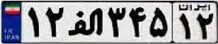

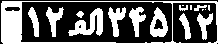

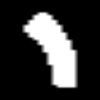

1/1 [==============================] - 9s 9s/step


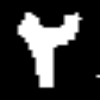

1/1 [==============================] - 0s 160ms/step


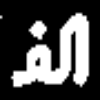

1/1 [==============================] - 0s 174ms/step


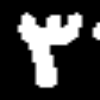

1/1 [==============================] - 0s 156ms/step


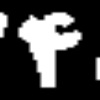

1/1 [==============================] - 0s 160ms/step


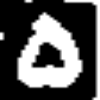

1/1 [==============================] - 0s 162ms/step


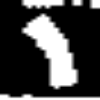

1/1 [==============================] - 0s 160ms/step


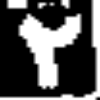

1/1 [==============================] - 0s 183ms/step
['one'] ['two'] ['alef'] ['two'] ['two'] ['five'] ['one'] ['two'] 


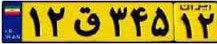

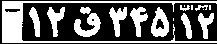

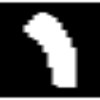

1/1 [==============================] - 0s 110ms/step


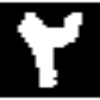

1/1 [==============================] - 0s 105ms/step


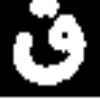

1/1 [==============================] - 0s 103ms/step


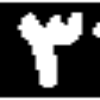

1/1 [==============================] - 0s 115ms/step


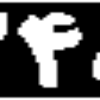

1/1 [==============================] - 0s 124ms/step


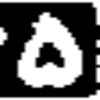

1/1 [==============================] - 0s 119ms/step


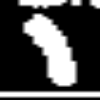

1/1 [==============================] - 0s 106ms/step


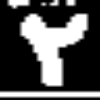

1/1 [==============================] - 0s 117ms/step
['one'] ['two'] ['ghe'] ['two'] ['two'] ['five'] ['one'] ['two'] 


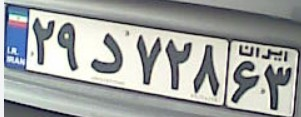

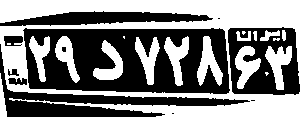

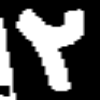

1/1 [==============================] - 0s 106ms/step


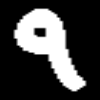

1/1 [==============================] - 0s 104ms/step


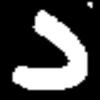

1/1 [==============================] - 0s 106ms/step


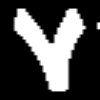

1/1 [==============================] - 0s 110ms/step


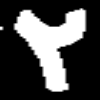

1/1 [==============================] - 0s 113ms/step


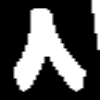

1/1 [==============================] - 0s 110ms/step


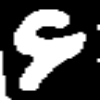

1/1 [==============================] - 0s 106ms/step


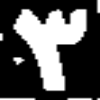

1/1 [==============================] - 0s 127ms/step
['one'] ['nine'] ['zal'] ['seven'] ['two'] ['eight'] ['v'] ['two'] 


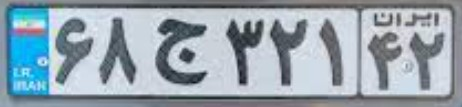

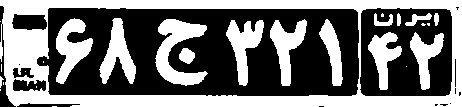

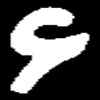

1/1 [==============================] - 0s 119ms/step


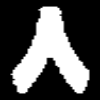

1/1 [==============================] - 0s 109ms/step


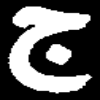

1/1 [==============================] - 0s 108ms/step


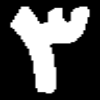

1/1 [==============================] - 0s 109ms/step


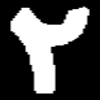

1/1 [==============================] - 0s 104ms/step


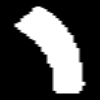

1/1 [==============================] - 0s 109ms/step


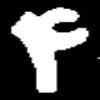

1/1 [==============================] - 0s 162ms/step


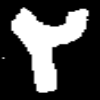

1/1 [==============================] - 0s 167ms/step
['zal'] ['g'] ['jim'] ['two'] ['two'] ['one'] ['two'] ['two'] 


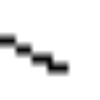

1/1 [==============================] - 0s 159ms/step
['v'] 


In [ ]:
# ### Cropping and Detecting the characters
# ## Implementing OpenCV consisting of image thresholding, contour detection, and bounding box extraction.

# plates_path = "/content/drive/MyDrive/Colab Notebooks/ComputerVision/Digit_Classification/Persian/CarNumberPlate/OnlyPlates"
# for plate_name in os.listdir(plates_path):
#   plate_path = os.path.join(plates_path, plate_name)
#   # Reading the image
#   plate_image = cv2.imread(plate_path)
#   cv2_imshow(plate_image)                                            ########
#   height, width, channel = plate_image.shape

#   ## Convert to Gray color
#   plate_gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
#   line_mask = np.copy(plate_image)
#   ## Detecting lines
#   ## Apply Canny edge detection
#   edges = cv2.Canny(plate_gray, 50, 150, apertureSize=3)
#   ## Perform the Hough Line Transform to detect the lines
#   lines = cv2.HoughLinesP(edges, rho=1, theta=(np.pi/180), threshold=10, minLineLength=10, maxLineGap=10)
#   line_max = 0
#   for line in lines:
#     ## Extract line coordinates
#     xl1, yl1, xl2, yl2 = line[0]
#     ## Draw lines on the mask
#     line_len = sqrt((xl2-xl1)**2 + (yl2-yl1)**2)
#     if line_len >= line_max:
#       line_max = line_len
#       x_1, y_1, x_2, y_2 = xl1, yl1, xl2, yl2
#       cv2.line(line_mask, (x_1, y_1), (x_2, y_2), color=[255], thickness=3)
#   # cv2_imshow(line_mask)                                                ########
#   ## angle of the longest line
#   angle = degrees(atan((y_2-y_1) / (x_2-x_1)))
#   ## Rotating the plate
#   cx , cy = width // 2 , height //2 
#   rotation_matrix = cv2.getRotationMatrix2D((cx,cy), angle, 1.0)
#   rotated_plate = cv2.warpAffine(plate_gray, rotation_matrix, (width, height))
#   # cv2_imshow(rotated_plate)                                            ########

#   ### Imgage Thresholding ###
#   _ , threshold = cv2.threshold(rotated_plate, 150,255, cv2.THRESH_BINARY_INV, cv2.THRESH_OTSU)
#   cv2_imshow(threshold)                                                ########

#   ## Contours Detection
#   contours , hierarchy = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#   ## Sorting contours from left
#   contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

#   labels = []
#   text = ""
#   for i,contour in enumerate(contours):
#     # making bounding rectangle arround each contour
#     x,y,w,h = cv2.boundingRect(contour)
#     ## Crop each character from threshold image (0,1) 
#     character = threshold[y:y+h, x:x+w]
    
#     ### Area filtering
#     plate_area = width * height
#     contour_area = w * h
#     constrain = contour_area >= plate_area / 40 and contour_area <= plate_area /8        

#     if constrain:                 
#       character = threshold[y-5:y+h+5, x-5:x+w+5]
#       character = cv2.resize(character, (100,100))
#       cv2_imshow(character)                                                     #######
#       chararray = img_to_array(character).reshape(1,100,100)
#       chararray = chararray / 255.0
        
#       ### Load Model
#       model_path = "/content/drive/MyDrive/Colab Notebooks/ComputerVision/Digit_Classification/Persian/PersianCNN_threshold.h5"
#       model = load_model(model_path)
#       ## Predicting Plate Charecters
#       prediction = model.predict(chararray)
      
#       ## Transforming to the original labels
#       class_names = ['alef', 'b', 'p', 't', 'se', 'jim', 'che', 'h', 'kh', 'd', 'zal', 'r', 'z', 'zh', 'sin', 'shin', 'sad', 'zad', 't-long', 'z-long', 'ayin', 'ghyin', 'f', 'ghe', 'k', 'g', 'le', 'm', 'n', 'v', 'he', 'ye', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'anewfive']
#       encoder = OneHotEncoder()
#       fitencoder = encoder.fit(np.array(class_names).reshape(-1,1))
#       label = fitencoder.inverse_transform(prediction)
#       # labels.append(label[0])
#       text = text + str(label[0]) + " "

#   print(text)
#   txt_name = plate_name[:-4] + ".txt"
#   txt_path = f"/content/drive/MyDrive/Colab Notebooks/ComputerVision/Digit_Classification/Persian/CarNumberPlate/TranslatedPlates/{txt_name}"
#   with open(txt_path, "w") as file:
#     file.write(text)